In [1]:
from datasets import load_dataset
import io
from PIL import Image
from matplotlib import pyplot as plt
from Network.Tinycnn import tinyNet
from torch import int64, float32
import torch
from tqdm import tqdm
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

/home/taehwan/micromamba/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
ds = load_dataset("flwrlabs/cinic10")
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 90000
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 90000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 90000
    })
})

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
from torch.nn.functional import one_hot
from Network.Loss import FocalLoss
def eval(net, valid_loader, e, lossf, DEVICE, Central=False):
    net.eval()
    Dicenary = {'accuracy':0, 'f1score':0}
    length = 0
    losses = 0
    for sample in tqdm(valid_loader, desc="Validation: "):
    
        X= torch.stack([torch.Tensor(np.array(s.convert("RGB"))) for s in sample["image"]], 0)
        Y= torch.Tensor(sample["label"])
        if len(sample) != 1:
            out = net(X.permute(0,3,1,2).squeeze().to(DEVICE)) 
            out = out.squeeze()
            Y = one_hot(Y.type(int64), 10).type(float32)
            losses += lossf(out.type(float32).to(DEVICE), Y.type(float32).to(DEVICE)).item()
        else:
            out = net(X.permute(0,3,1,2).squeeze().unsqueeze(0).to(DEVICE))
            out = out.squeeze()
            Y = one_hot(Y.type(int64), 10).type(float32)
            losses += lossf(out.type(float32).to(DEVICE), Y.type(float32).to(DEVICE)).item()
        out = out.softmax(1).argmax(1)
        Dicenary[f"accuracy"] += accuracy_score(out.cpu().detach().numpy(), Y.squeeze().argmax(1).type(int64).cpu().detach().numpy())
        Dicenary[f"f1score"] += f1_score(out.cpu().detach().numpy(), Y.squeeze().argmax(1).type(int64).cpu().detach().numpy(), average="weighted")
        length += 1
    # if Central:
        # logger.info(f"Result epoch {e+1}: loss:{losses/length} accuracy: {Dicenary["accuracy"]/length: .4f} f1score: {Dicenary["f1score"]/length: .4f}")
        
    return {"loss":losses/length, 'accuracy': Dicenary["accuracy"]/length , "f1score":Dicenary["f1score"]/length}

In [ ]:
#FedAvg
net = tinyNet(10).to(DEVICE)
net.load_state_dict(torch.load("./Models/FedAvgCINIC/net.pt",weights_only=True))
net.eval()
eval(net, ds["test"].to_iterable_dataset().batch(256), 0, FocalLoss(), DEVICE, Central=False)

Validation: : 352it [00:15, 22.31it/s]


{'loss': 5.32113136892969,
 'accuracy': 0.12369051846590909,
 'f1score': 0.10480692078311359}

In [ ]:
#FedProx
net = tinyNet(10).to(DEVICE)
net.load_state_dict(torch.load("./Models/FedProxCINIC/net.pt",weights_only=True))
net.eval()
eval(net, ds["test"].to_iterable_dataset().batch(256), 0, FocalLoss(), DEVICE, Central=False)

Validation: : 352it [00:16, 21.46it/s]


{'loss': 15.454449011520905,
 'accuracy': 0.11078805634469698,
 'f1score': 0.020046114581159756}

In [ ]:
#FedOpt
net = tinyNet(10).to(DEVICE)
net.load_state_dict(torch.load("./Models/FedOptCINIC/net.pt",weights_only=True))
net.eval()
eval(net, ds["test"].to_iterable_dataset().batch(256), 0, FocalLoss(), DEVICE, Central=False)

Validation: : 352it [00:16, 21.65it/s]


{'loss': 15.40472817488692,
 'accuracy': 0.11154267282196971,
 'f1score': 0.02023566177176632}

In [ ]:
#FedRef
net = tinyNet(10).to(DEVICE)
net.load_state_dict(torch.load("./Models/FedRefCINIC/net_lda0.1_p3_6.pt",weights_only=True))
net.eval()
eval(net, ds["test"].to_iterable_dataset().batch(256), 0, FocalLoss(), DEVICE, Central=False)

Validation: : 352it [00:16, 21.49it/s]


{'loss': 0.10322722294156185,
 'accuracy': 0.09987571022727272,
 'f1score': 0.10019963144963145}

In [2]:
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import colors as mcolors
import matplotlib.pyplot as plt
def ploting(fedavg, fedprox, fedref, title="MNIST Classification", zoom_min = 20, zoom_max=25, inset=True, metric="loss", minimum_y=0):
    # 예시 데이터
    tableau_colors = list(mcolors.TABLEAU_COLORS.values())
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(fedavg[metric], marker=".",linestyle="--",label="fedavg", color=tableau_colors[0], alpha=1)
    ax.plot(fedprox[metric], marker=".", linestyle="--" ,label="fedprox(μ=0.5)", color=tableau_colors[1], alpha=0.5)
    for i,l in enumerate(fedref):
        ax.plot(l[metric], marker=".", label=l["label"], color=tableau_colors[i+2], linestyle="--", alpha=0.7)

    # 메인 축 설정
    ax.set_title(title)
    ax.set_xlabel("Round")
    ax.set_ylabel(metric)
    ax.legend()
    # 🔍 확대 구간 설정 (마지막 x값 근처, 예: x > 90)
    x_zoom_min = zoom_min
    x_zoom_max = zoom_max

    # inset 축 생성
    if inset:
        axins = inset_axes(ax, width="30%", height="40%", loc='lower right')
        axins.plot(fedavg[metric], color =tableau_colors[0], label = "fedavg", marker=".", alpha=0.7, linestyle="--")
        axins.plot(fedprox[metric], color =tableau_colors[1], label = "fedprox", linestyle="--", marker= ".", alpha=0.9)
        for i,l in enumerate(fedref):
            axins.plot(l[metric], label=l["label"], color=tableau_colors[i+2], linestyle="--", marker=".")

        alp = fedavg[metric][zoom_min:zoom_max+1].to_list() + fedprox[metric][zoom_min:zoom_max+1].to_list()
        for l in fedref:
            alp = alp + l[metric][zoom_min:zoom_max+1].to_list()

        axins.set_xlim(x_zoom_min, x_zoom_max)
        #확대된 y축 범위도 지정하면 보기 쉬움
        #y_zoom = y[(x >= x_zoom_min) & (x <= x_zoom_max)]
        axins.set_ylim(bottom=min(alp), top = max(alp))
        
        # 확대된 영역 표시선 연결
        ax.indicate_inset_zoom(axins)
    ax.legend(fontsize=11)

    minimum = [fedavg[metric].min(), fedprox[metric].min()] + [ s[metric].min() for s in fedref]
    # minimum = min(minimum)
    # ax.set_ylim(bottom=minimum-minimum_y)


    fig.show()

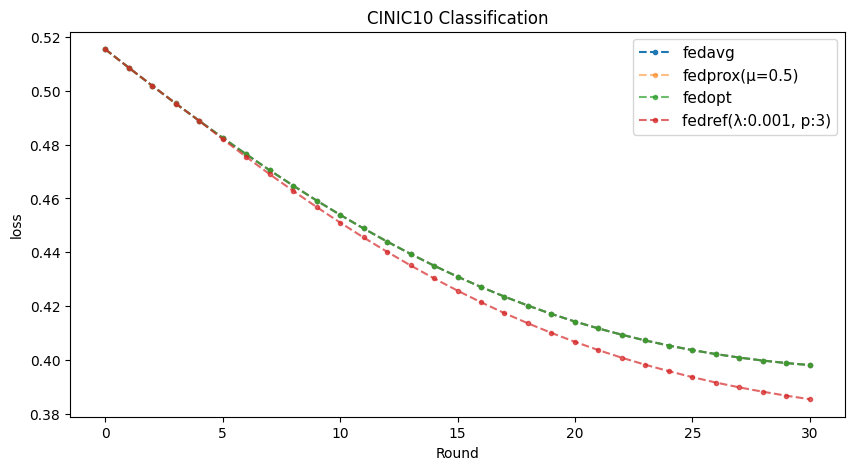

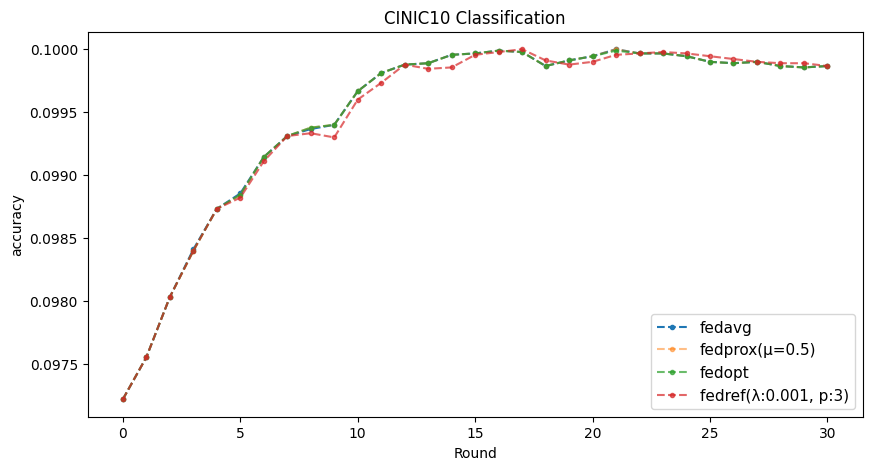

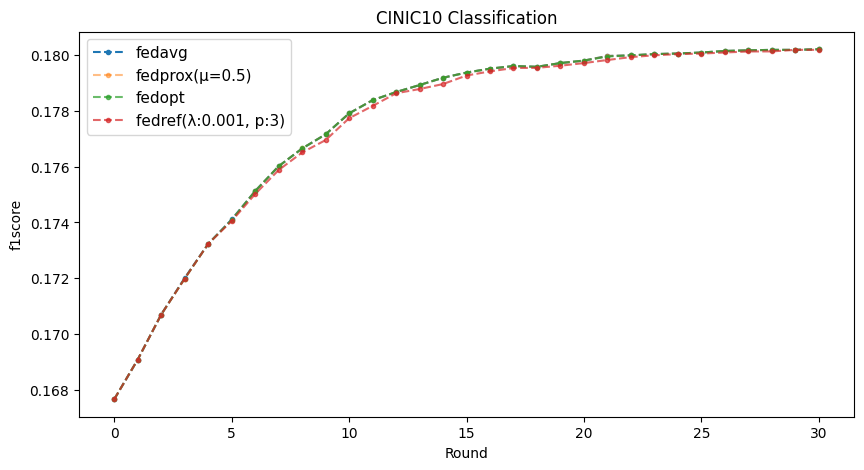

In [4]:
fedavg = pd.read_csv("Result/fedavg/fedavg_cinic10.csv")
fedprox = pd.read_csv("Result/fedprox/fedprox_cinic10.csv")
fedopt = pd.read_csv("Result/fedopt/fedopt_cinic10.csv")
fedref = [{**fedopt.to_dict("series"), **{"label":"fedopt"}},
    {**pd.read_csv("./Result/fedref/fedref_cinic10_lda0.01_p3.csv").to_dict("series"), **{"label":"fedref(λ:0.001, p:3)"}}
    ]
ploting(fedavg, fedprox, fedref, title="CINIC10 Classification", zoom_min = 20, zoom_max=25, inset=False, metric="loss")
ploting(fedavg, fedprox, fedref, title="CINIC10 Classification", zoom_min = 20, zoom_max=25, inset=False, metric="accuracy")
ploting(fedavg, fedprox, fedref, title="CINIC10 Classification", zoom_min = 20, zoom_max=25, inset=False, metric="f1score")

In [ ]:
plt.bar(range(10), [9000]*10)
plt.xlabel("Subset ID")
plt.ylabel("Volumes")
plt.title("Number of clients' samples from Cinic10 dataset")